# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

# 项目概述

* 项目概述

该数据集是一个音乐服务的用户日志，包含了用户信息，歌曲信息，用户活动，时间戳等。我们尝试分析日志，提取与用户流失相关的变量，并使用Spark建立模型去识别可能流失的用户，以便于后续采取措施挽留用户

* 项目思路
  * 1.加载库，创建Spark session
  * 2.加载与清洗数据
  * 3.探索性数据分析，寻找变量间关系
  * 4.构建用于预测的特征
  * 5.建模预测
  * 6.结论汇总
  
* 评价指标
  * 因为流失顾客数据集很小，Accuracy很难反映模型好坏，根据建议选用 F1 score 作为优化指标


In [1]:
# import libraries
#加载pyspark相关的库
from pyspark.sql.functions import avg,col,concat,desc,explode,lit,min,max,split,udf
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql import SparkSession

#from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,LinearSVC,RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler,VectorAssembler
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

#加载pandas、numpy、matplotlib、seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#加载datetime
import datetime
from time import time


In [2]:
# create a Spark session
spark=SparkSession.builder.getOrCreate()

# 1加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

### 1.1 加载数据

In [3]:
#读取数据
df=spark.read.json('mini_sparkify_event_data.json.bz2')

### 1.2 评估数据

In [4]:
#查看数据前5行
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [5]:
#查看各列
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.count()

286500

* 数据集共有286500行,18列
* 连续变量有itemInSession\length\sessionId\registration\ts, 剩下变量均为分类变量

In [7]:
#查看ID列
df.select('userId').dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



#### 分析：
* userId列存在非NA的空值，需要删除

In [8]:
#查看page列取值情况
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



### 1.3清理

* 删除ID列NA，及空值

In [9]:
#删除NA值及非NA空值
df_clean=df.dropna(how="any",subset=["userId","sessionId"])
df_clean=df_clean.filter(df["userId"]!="")

In [10]:
#检查结果
df_clean.select('userId').dropDuplicates().sort('userId').show(5)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
+------+
only showing top 5 rows



# 2探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 2.1定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。



In [11]:
#创建一列作为Cancellation Confirmation事件标签
flag_churn=udf(lambda x:1 if x=='Cancellation Confirmation' else 0,IntegerType())
df_clean=df_clean.withColumn('churn_event',flag_churn("page"))

In [12]:
#创建一列作为Cancellation Confirmation/流失用户标签
windowval=Window.partitionBy('userId')
df_clean=df_clean.withColumn('churn_user',max('churn_event').over(windowval))

### 2.2探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

#### 2.2.1是否注销与添加播放列表关系

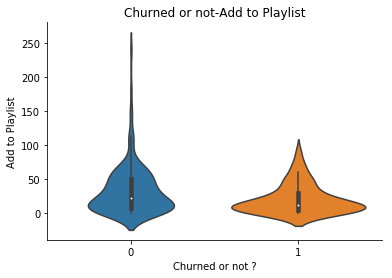

In [13]:
#提取Add to Playlist数据，查看用户添加至播放列表数量的分布
lifetime_songs=df_clean.where('page=="Add to Playlist"').groupby(['userId','churn_user']).count().toPandas()

#绘制小提琴图
ax=sns.violinplot(data=lifetime_songs,x='churn_user',y='count')
plt.xlabel('Churned or not ?')
plt.ylabel('Add to Playlist')
plt.title('Churned or not-Add to Playlist')
sns.despine(ax=ax)

* 相比于非注销用户，注销用户将歌曲添加至播放列表的数量较少，且数量的分布相对集中，其小提琴图形相对扁平

#### 2.2.2是否注销与添加好友数量

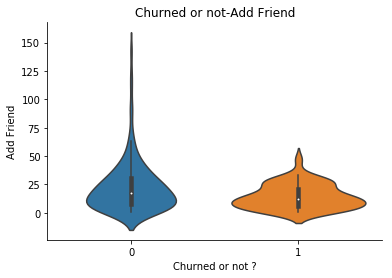

In [14]:
#提取Add Friend数据，观察用户添加好友分布
add_friend=df_clean.where('page=="Add Friend"').groupby(['userId','churn_user']).count().toPandas()

ax=sns.violinplot(data=add_friend,x='churn_user',y='count')
plt.xlabel('Churned or not ?')
plt.ylabel('Add Friend')
plt.title('Churned or not-Add Friend')
sns.despine(ax=ax)

* 相比于非注销用户，注销用户添加好友的数量大多处于较低水平；非注销用户添加好友数量从高水平到低水平均有分布，且非注销用户添加好友数量最大值远远大于注销用户的最大值

#### 2.2.3是否注销与性别关系

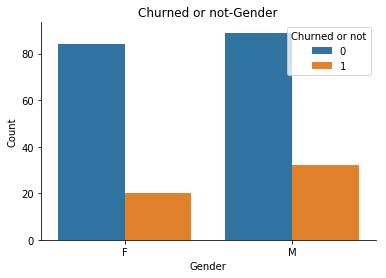

In [15]:
#提取性别与用户ID列，观察注销与性别间关系
gender_churn=df_clean.dropDuplicates(["userId","gender"]).groupby(["churn_user","gender"]).count().toPandas()

#绘制直方图
ax=sns.barplot(x='gender',y='count',hue='churn_user',data=gender_churn)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Churned or not',loc='best')
plt.title('Churned or not-Gender')
sns.despine(ax=ax)

* 男性用户注销账户的绝对人数以及比例均比女性大

# 3特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

### 5.1构建变量

结合经验及以上的分析，构建以下变量：
* 用户听歌数量：听歌数量越大，说明用户愿意使用该服务，注销几率越小。
* 差评量：差评越多，说明用户不喜欢该服务，注销几率越大。
* 添加播放列表量：用户将歌曲加进播放列表，一般可说明用户喜欢该音乐；添加的量越多，用户愿意使用该服务的可能性越大，注销可能性越小。
* 添加好友量：添加好友量越多，说明用于越愿意在改服务中交友分享，注销几率越小。
* 用户单次（同一sessionId）听歌最大数量：单次听歌数量越大，说明用户愿意使用该服务，注销几率越小
* 播放的歌手数量：播放过的歌手数量越多，侧面说明用户听歌越多，越愿意使用该服务，注销几率越小。
* 用户等级：用户曾经有付费，说明用户对该服务还是感兴趣的，注销几率相对小

In [16]:
#用户听歌数量
#获取每个用户点击页面NextSong的数量信息计数，获得用户添加进播放列表数量
feature_1=df_clean.select('userId','page').where(df_clean.page=="NextSong").groupBy('userId').count().withColumnRenamed('count','song_total')
feature_1.show(5)

+------+----------+
|userId|song_total|
+------+----------+
|100010|       275|
|200002|       387|
|   125|         8|
|    51|      2111|
|   124|      4079|
+------+----------+
only showing top 5 rows



In [17]:
#添加进播放列表量
#获取每个用户点击页面Add to Playlist的数量信息计数，可获得用户添加进播放列表数量
feature_2=df_clean.select('userId','page').where(df_clean.page=='Add to Playlist').groupBy('userId').count().withColumnRenamed('count','add_to_playlist')
feature_2.show(5)

+------+---------------+
|userId|add_to_playlist|
+------+---------------+
|100010|              7|
|200002|              8|
|    51|             52|
|   124|            118|
|     7|              5|
+------+---------------+
only showing top 5 rows



In [18]:
#添加好友量
#获取每个用户点击页面Add Friend的数量信息计数，可获得用户添加好友书量
feature_3=df_clean.select('userId','page').where(df_clean.page=='Add Friend').groupBy('userId').count().withColumnRenamed('count','add_friend')
feature_3.show(5)

+------+----------+
|userId|add_friend|
+------+----------+
|100010|         4|
|200002|         4|
|    51|        28|
|   124|        74|
|     7|         1|
+------+----------+
only showing top 5 rows



In [19]:
#差评量
#获取每个用户点击页面Thumbs Down的数量信息计数，可获得用户差评量
feature_4=df_clean.select('userID','page').where(df_clean.page=='Thumbs Down').groupBy('userId').count().withColumnRenamed('count','Thumbs Down')
feature_4.show(5)

+------+-----------+
|userId|Thumbs Down|
+------+-----------+
|100010|          5|
|200002|          6|
|    51|         21|
|   124|         41|
|     7|          1|
+------+-----------+
only showing top 5 rows



In [20]:
#用户单次（同一sessionId）听歌最大数量
#获取每个sessionId点击页面NextSong数量信息并计数，并按用户求最大，可获得用户单次（同一sessionId）听歌最大数量
feature_5=df_clean.where('page=="NextSong"').groupBy('userId','sessionId').count().groupBy(['userId']).agg({'count':'max'}).withColumnRenamed('max(count)','max_songs_played')
feature_5.show(5)

+------+----------------+
|userId|max_songs_played|
+------+----------------+
|100010|              80|
|200002|             120|
|   125|               8|
|    51|             497|
|   124|             434|
+------+----------------+
only showing top 5 rows



In [21]:
#播放的歌手数量
#获取每个用户点击页面NextSong时的artist信息并计数，可获得用户听过的歌手数量
feature_6=df_clean.filter(df_clean.page=="NextSong").select("userId","artist").dropDuplicates().groupby("userId").count().withColumnRenamed("count","artist_total")
feature_6.show(5)

+------+------------+
|userId|artist_total|
+------+------------+
|100010|         252|
|200002|         339|
|   125|           8|
|    51|        1385|
|   124|        2232|
+------+------------+
only showing top 5 rows



In [22]:
#是否曾经付费
#将level中free/paid转换为0/1；只有用户曾经付费，标记为1
windowval_feature=Window.partitionBy('userId')
feature_7=df_clean.select('userId','level').replace(['free', 'paid'],['0','1'],'level').select('userId', col('level').cast('int'))
feature_7=feature_7.withColumn('level_max',max('level').over(windowval_feature)).drop('level').dropDuplicates()
feature_7.show(10)

+------+---------+
|userId|level_max|
+------+---------+
|100010|        0|
|200002|        1|
|   125|        0|
|   124|        1|
|    51|        1|
|     7|        0|
|    15|        1|
|    54|        1|
|   155|        1|
|100014|        1|
+------+---------+
only showing top 10 rows



In [23]:
#标签
label=df_clean.select('userId',col('churn_user').alias('label')).dropDuplicates()
label.show(5)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



### 5.2变量聚合

In [24]:
#汇总特征数据与标签
df_feature=feature_1.join(feature_2,'userId','outer')\
    .join(feature_3,'userId','outer')\
    .join(feature_4,'userId','outer')\
    .join(feature_5,'userId','outer')\
    .join(feature_6,'userId','outer')\
    .join(feature_7,'userId','outer')\
    .join(label,'userId','outer')

df_feature=df_feature.fillna(0)#无值的，用0填充
df_feature=df_feature.drop('userId')#删除索引
df_feature.show(5)

+----------+---------------+----------+-----------+----------------+------------+---------+-----+
|song_total|add_to_playlist|add_friend|Thumbs Down|max_songs_played|artist_total|level_max|label|
+----------+---------------+----------+-----------+----------------+------------+---------+-----+
|       275|              7|         4|          5|              80|         252|        0|    0|
|       387|              8|         4|          6|             120|         339|        1|    0|
|         8|              0|         0|          0|               8|           8|        0|    1|
|      4079|            118|        74|         41|             434|        2232|        1|    0|
|      2111|             52|        28|         21|             497|        1385|        1|    1|
+----------+---------------+----------+-----------+----------------+------------+---------+-----+
only showing top 5 rows



# 4建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

### 4.1准备数据

In [25]:
#用VectorAssembler将数据集转换为可供模型计算的结构
cols=["song_total","add_to_playlist","add_friend","Thumbs Down","max_songs_played","artist_total","level_max"]
assembler=VectorAssembler(inputCols=cols,outputCol="features_vec")
df_feature=assembler.transform(df_feature)#转成向量
df_feature.show()

+----------+---------------+----------+-----------+----------------+------------+---------+-----+--------------------+
|song_total|add_to_playlist|add_friend|Thumbs Down|max_songs_played|artist_total|level_max|label|        features_vec|
+----------+---------------+----------+-----------+----------------+------------+---------+-----+--------------------+
|       275|              7|         4|          5|              80|         252|        0|    0|[275.0,7.0,4.0,5....|
|       387|              8|         4|          6|             120|         339|        1|    0|[387.0,8.0,4.0,6....|
|         8|              0|         0|          0|               8|           8|        0|    1|(7,[0,4,5],[8.0,8...|
|      4079|            118|        74|         41|             434|        2232|        1|    0|[4079.0,118.0,74....|
|      2111|             52|        28|         21|             497|        1385|        1|    1|[2111.0,52.0,28.0...|
|       150|              5|         1|         

In [26]:
#用StandardScaler标准化数据
scaler=StandardScaler(inputCol="features_vec",outputCol="features",withStd=True)
scalerModel=scaler.fit(df_feature)
df_feature=scalerModel.transform(df_feature)
df_feature.show()

+----------+---------------+----------+-----------+----------------+------------+---------+-----+--------------------+--------------------+
|song_total|add_to_playlist|add_friend|Thumbs Down|max_songs_played|artist_total|level_max|label|        features_vec|            features|
+----------+---------------+----------+-----------+----------------+------------+---------+-----+--------------------+--------------------+
|       275|              7|         4|          5|              80|         252|        0|    0|[275.0,7.0,4.0,5....|[0.24887761207221...|
|       387|              8|         4|          6|             120|         339|        1|    0|[387.0,8.0,4.0,6....|[0.35023867589799...|
|         8|              0|         0|          0|               8|           8|        0|    1|(7,[0,4,5],[8.0,8...|(7,[0,4,5],[0.007...|
|      4079|            118|        74|         41|             434|        2232|        1|    0|[4079.0,118.0,74....|[3.69153374415482...|
|      2111|        

In [27]:
#拆分为训练集、测试集和验证集
train,validation,test=df_feature.randomSplit([0.6,0.2,0.2],seed=42)

### 4.2模型选择

#### 4.2.1模型选择思路

* 选用逻辑回归、支持向量机、随机森林进行对比，这几个模型一般不需要很多参数调整就可以达到不错的效果。他们的优缺点如下：
  * 1、逻辑回归：优点：计算速度快；缺点：容易产生欠拟合。
  * 2、支持向量机：数据量较小情况下解决机器学习问题。缺点：对缺失数据敏感
  * 3、随机森林：优点：有抗过拟合能力。通过平均决策树，降低过拟合的风险性。缺点：大量的树结构会占用大量的空间和利用大量时间

#### 4.2.2LogisticRegression

In [28]:
#创建并训练模型，通过time()记录训练时间
lr=LogisticRegression(maxIter=10)#初始化
start=time()#开始时间
model_lr=lr.fit(train)#训练
end=time()#结束时间
print('The training process took{} second'.format(end-start))

The training process took116.791512966156 second


In [29]:
#验证模型效果
results_lr=model_lr.transform(validation)#验证集上预测
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")#评分器
print('Logistic Regreession Metrics:')
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr,{evaluator.metricName:"f1"})))#计算F-1 Score

Logistic Regreession Metrics:
Accuracy:0.7755102040816326
F-1 Score:0.7096869517037585


#### 4.2.3LinearSVC

In [30]:
#创建并训练模型
svm=LinearSVC(maxIter=10)
start=time()
model_svm=svm.fit(train)
end=time()
print('The training process took{} second'.format(end-start))

The training process took207.28921794891357 second


In [31]:
#验证模型效果
results_svm=model_svm.transform(validation)
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")#
print('LinearSVC:')
print('F-1 Score:{}'.format(evaluator.evaluate(results_svm,{evaluator.metricName:"f1"})))

LinearSVC Metrics:
Accuracy:0.7755102040816326
F-1 Score:0.6774571897724607


#### 4.2.4Random Forest

In [32]:
#创建并训练模型，通过time()记录训练时间
rf=RandomForestClassifier(seed=42)#初始化
start=time()#开始时间
model_rf=rf.fit(train)#训练
end=time()#结束时间
print('The training process took{} second'.format(end-start))

The training process took209.9560685157776 second


In [33]:
#验证模型效果
results_rf=model_rf.transform(validation)#验证集上预测
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")#评分器
print('Random Forest:')
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf,{evaluator.metricName:"f1"})))#计算F-1 Score

Random Forest Metrics:
Accuracy:0.7755102040816326
F-1 Score:0.7096869517037585


In [34]:
#创建并训练模型，通过time()记录训练时间
rf_2=RandomForestClassifier(seed=42)#初始化
start=time()#开始时间
model_rf_2=rf_2.fit(train)#训练
end=time()#结束时间
print('The training process took{} second'.format(end-start))

The training process took205.05550479888916 second


In [35]:
#验证模型效果
results_rf_2=model_rf_2.transform(validation)#验证集上预测
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")#评分器
print('Random Forest:')
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf_2,{evaluator.metricName:"f1"})))#计算F-1 Score

Random Forest Metrics:
Accuracy:0.7755102040816326
F-1 Score:0.7096869517037585


#### 4.2.6模型总结

* LogisticRegression模型：F-1 Score为0.7096；耗时121s
* LinearSVC模型：F-1 Score为0.6775；耗时214s
* Random Forest模型：F-1 Score0.7096；耗时215s

LogisticRegression、Random Forest的F-1 Score一致，且较LinearSVC的高。为了避免过拟合，选取Random Forest作为最终模型，选用并通过调节模型参数尝试获取更优模型

### 4.3模型调优

* 如上所述，选用Random Forest进行调优
* 因为流失顾客数据集很小，Accuracy很难反映模型好坏，根据建议选用 F1 score 作为优化指标。
* 使用3折交叉验证及参数网络对模型尝试调优

In [36]:
#创建模型
rf=RandomForestClassifier(seed=42)
f1_evaluator=MulticlassClassificationEvaluator(metricName='f1')

paramGrid=ParamGridBuilder().addGrid(rf.maxDepth,[10,20]).addGrid(rf.numTrees,[50,100]).build()#原来3,5,20,50更优；看了减少点。没有过拟合，泛化嫩里还很好

crossval_rf=CrossValidator(estimator=rf,
        estimatorParamMaps=paramGrid,
        evaluator=f1_evaluator,
        numFolds=3)

In [37]:
#训练并获取最佳参数
cvModel_rf=crossval_rf.fit(train)
cvModel_rf.avgMetrics

[0.743849355866234, 0.7515627752177565, 0.743849355866234, 0.7515627752177565]

In [38]:
#验证调优后效果
results_rf_cv=cvModel_rf.transform(validation)
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
print('Crossval Random Forest:')
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf_cv,{evaluator.metricName:"f1"})))

Crossval Random Forest Metrics:
Accuracy:0.7959183673469388
F-1 Score:0.7227495649422561


* 对比调优前后的模型在验证集上预测结果，调优前F-1 Score0.7096；调优后F-1 Score:0.7227，F-1 Score有提升
* 使用调优后模型进行最终预测

### 4.4使用最佳模型预测

In [40]:
#使用最佳模型预测
results_final=cvModel_rf.transform(test)
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test:')
print('F-1 Score:{}'.format(evaluator.evaluate(results_final,{evaluator.metricName:"f1"})))

Test:
Accuracy:0.7058823529411765
F-1 Score:0.6591970121381886


* 在测试集上运算后：F-1 Score:0.6591，和在验证集的结果上相比，F-1 Score有下降
* 模型存在在过拟合

# 5总结

### 5.1总结&反思

* 过程总结
    * 这个项目中，我们建立了一个预测流失用户的模型。
    * 在数据集中，我们删除了没有用户ID和sessionID的数据；对流失用户建立了标识，并结合对特征与是否流失间关系的探索，并建立了7个特征
    * 然后我们选择3个模型：逻辑回归，SVM和随机森林进行比较。根据比较结果。选择了随机森林预测最后结果。
    * 接着我们使用交叉验证和参数网络搜索调优随机森林的参数，对测试集进行预测。预测结果F-1 Score:0.6591

* 过程反思
    * 构建合适的特征对于建立好的模型十分重要。而数据集中，现成的可用于预测的特征并不多；我们需要重新构造特征来预测流失用户。而从数据集中构造变量一方面需要经验与知识的积累，一方面需要熟悉手上的数据
    * 对比各未经优化的模型间F-1 Score，各模型相差不大。后续想有较大幅度提升，除了选取更优模型，更多可能需要从创建更合适的特征变量入手

### 5.3改进

1、该数据集放在现实中，数据量并不大。如果进一步增加数据量，可以得到预测效果更好的模型

2、用于预测流失用户的特征进一步增加完善，找到与数据集相关性更强的特征，以提升模型性能。如增加用户注销账户时的的等级作为特征；或者对未理解未探索的特征进一步研究

3、模型方面：选用决策树、梯度提升树等其他算法，观察accuracy与f1分数变化，对比已使用的算法，选取更优模型

# 6最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。